################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################



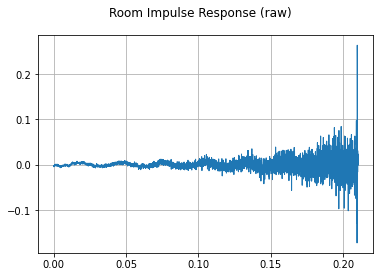

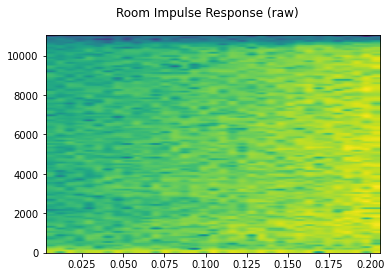

In [1]:
from augmentation_utils import _get_sample, get_rir_sample, plot_waveform, plot_specgram, play_audio, get_speech_sample
import os
_SAMPLE_DIR = "_sample_data"
SAMPLE_RIR_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/distant-16k/room-response/rm1/impulse/Lab41-SRI-VOiCES-rm1-impulse-mc01-stu-clo.wav"
SAMPLE_RIR_PATH = os.path.join(_SAMPLE_DIR, "rir.wav")
sample_rate = 22050

rir, _ = get_rir_sample(SAMPLE_RIR_PATH, sample_rate)
plot_waveform(rir, sample_rate, title="Room Impulse Response (raw)", ylim=None)
plot_specgram(rir, sample_rate, title="Room Impulse Response (raw)")
play_audio(rir, sample_rate)

torch.Size([1, 54400])
torch.Size([1, 54400])


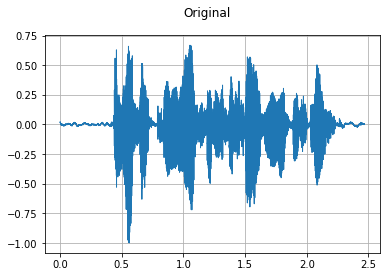

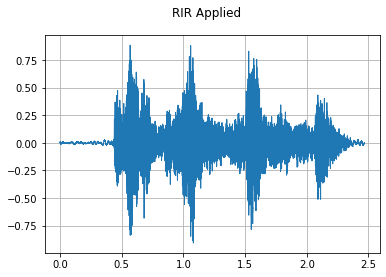

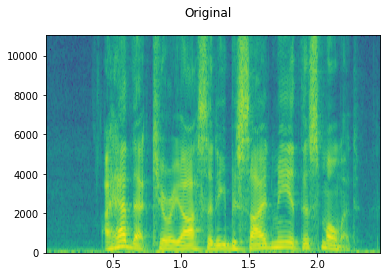

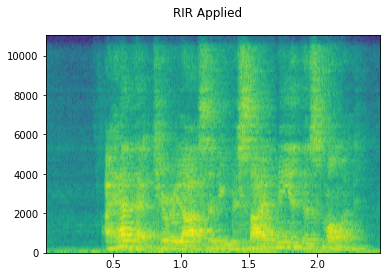

In [2]:
import torch
import os
SAMPLE_WAV_SPEECH_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"
SAMPLE_WAV_SPEECH_PATH = os.path.join(_SAMPLE_DIR, "speech.wav")
speech, _ = get_speech_sample(SAMPLE_WAV_SPEECH_PATH, resample=None)
print(speech.size())
speech_ = torch.nn.functional.pad(speech, (rir.shape[1]-1, 0))
augmented = torch.nn.functional.conv1d(speech_[None, ...], rir[None, ...])[0]
print(augmented.size())

plot_waveform(speech, sample_rate, title="Original", ylim=None)
plot_waveform(augmented, sample_rate, title="RIR Applied", ylim=None)

plot_specgram(speech, sample_rate, title="Original")
play_audio(speech, sample_rate)

plot_specgram(augmented, sample_rate, title="RIR Applied")
play_audio(augmented, sample_rate)

In [14]:
from transformers import Wav2Vec2Model, Wav2Vec2Config

# Initializing a Wav2Vec2 facebook/wav2vec2-base-960h style configuration
configuration = Wav2Vec2Config()

# Initializing a model from the facebook/wav2vec2-base-960h style configuration
model = Wav2Vec2Model(configuration)

# Accessing the model configuration
configuration = model.config

In [18]:
# print(model.train())
results = model(speech[:, 0:8192])
print(speech[:, 0:8192].size(), results.last_hidden_state.size())

results = model(speech)
print(speech.size(), results.last_hidden_state.size())

torch.Size([1, 8192]) torch.Size([1, 25, 768])
torch.Size([1, 54400]) torch.Size([1, 169, 768])


In [25]:
print(speech.size(), results.extract_features.size())

torch.Size([1, 54400]) torch.Size([1, 25, 512])


In [13]:
sum(p.numel() for p in model.parameters())

94371712

In [17]:
print(results.last_hidden_state.size(), results.extract_features.size()) # hidden_states是过完transformer的，extract_features是过完Conv的

torch.Size([1, 169, 768]) torch.Size([1, 169, 512])


In [2]:
import fairseq
import torch
import soundfile as sf

cp = './source_models/wav2vec_large.pt'
model, cfg, task = fairseq.checkpoint_utils.load_model_ensemble([cp])
model = model[0]

audio_input = torch.randn(1,10000)
z = model.feature_extractor(audio_input)
c = model.feature_aggregator(z)

OSError: Model file not found: ./source_models/wav2vec_large.pt

In [1]:
import torch 
import torchaudio
from torchaudio.models import Conformer
conformer = Conformer(input_dim=80,num_heads=4,ffn_dim=128,num_layers=4,depthwise_conv_kernel_size=31)
lengths = torch.randint(1, 400, (10,))  # (batch,)
nnnn = torch.rand(10, int(lengths.max()), 80)  # (batch, num_frames, input_dim)
output = conformer(nnnn, lengths)
print

################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################



ImportError: cannot import name 'Conformer' from 'torchaudio.models' (/usr/local/lib/python3.7/dist-packages/torchaudio/models/__init__.py)

In [6]:
print(output[1].size())

torch.Size([10])


In [5]:
print(int(lengths.max()))

354


In [10]:
from torch import nn
import torch
m = nn.Conv1d(1, 32, 10, stride=5)
m1 = nn.Conv1d(32, 64, 3, stride=2)
m2 = nn.Conv1d(64, 128, 3, stride=2)
m3 = nn.Conv1d(128, 128, 3, stride=2)
m4 = nn.Conv1d(128, 64, 2, stride=2)
# m5 = nn.Conv1d(64, 32, 2, stride=2)
x = torch.randn(64, 1, 8192)
x = m(x)
print(x.size())
x = m1(x)
print(x.size())
x = m2(x)
print(x.size())
x = m3(x)
print(x.size())
x = m4(x)
print(x.size())
x = m5(x)
print(x.size())

torch.Size([64, 32, 1637])
torch.Size([64, 64, 818])
torch.Size([64, 128, 408])
torch.Size([64, 128, 203])
torch.Size([64, 64, 101])
torch.Size([64, 32, 50])


In [1]:
from torch import nn
import torch
import modules
from torch.nn.utils import weight_norm, remove_weight_norm, spectral_norm
from torch.nn import functional as F
norm_f = weight_norm
convs = nn.ModuleList([
            norm_f(nn.Conv1d(1, 16, 15, 1, padding=7)),
            norm_f(nn.Conv1d(16, 64, 41, 4, groups=4, padding=20)),
            norm_f(nn.Conv1d(64, 256, 41, 4, groups=16, padding=20)),
            norm_f(nn.Conv1d(256, 1024, 41, 4, groups=64, padding=20)),
            norm_f(nn.Conv1d(1024, 1024, 41, 4, groups=256, padding=20)),
            norm_f(nn.Conv1d(1024, 1024, 5, 1, padding=2)),
        ])
conv_post = norm_f(nn.Conv1d(1024, 1, 3, 1, padding=1))
x = torch.randn(64, 1, 8192)
for l in convs:
    x = l(x)
    x = F.leaky_relu(x, modules.LRELU_SLOPE)
    print(x.size())
x = conv_post(x)
print(x.size())
x = torch.flatten(x, 1, -1)
print(x.size())

torch.Size([64, 16, 8192])
torch.Size([64, 64, 2048])
torch.Size([64, 256, 512])
torch.Size([64, 1024, 128])
torch.Size([64, 1024, 32])
torch.Size([64, 1024, 32])
torch.Size([64, 1, 32])
torch.Size([64, 32])


In [1]:
import os 
os.system('hdfs dfs -rm -f hdfs://haruna/home/byte_arnold_hl_speech_asr/user/xinghua/vits.tar._COPYING_')

rm: Failed to move to trash: hdfs://haruna/home/byte_arnold_hl_speech_asr/user/xinghua/vits.tar._COPYING_: GDPR permission denied. ensure user/psm has access right. https://bytedance.feishu.cn/space/doc/doccnplPwh5dmvqMY22f1C user=xinghua.qu psm=lab.speech.bytespeech_hdfs_fusion, inode=/home/byte_arnold_hl_speech_asr/user/xinghua/vits.tar._COPYING_


256

In [ ]:
import pandas as pd
df = pd.read_csv ('./results/mel_w_1/tensorboard/rir_evaluate/accuracy.csv')
print (df.mean())
print(df.std())


In [1]:
import glob
import librosa
import soundfile
directory = './background_noise/rir_audios'
SAMPLE_RATE = 22050
for filename in glob.iglob(f'{directory}/*'):
    y, sr = librosa.load(filename)
    data = librosa.resample(y, sr, SAMPLE_RATE)
    soundfile.write('{}'.format(filename), data, SAMPLE_RATE)